<a href="https://colab.research.google.com/github/kridtapon/WFO-Squeeze-Pop-Strategy/blob/main/WFO_Squeeze_%26_Pop_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
pip install vectorbt

[*********************100%***********************]  1 of 1 completed
<ipython-input-30-7407d060fcc5>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-30-7407d060fcc5>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-30-7407d060fcc5>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide


Walk-Forward Optimization Results:
   Year   Best_Params  Test_Return
0  2020    (11, 2, 5)     0.840185
1  2021     (8, 2, 2)     0.430880
2  2022  (22, 2.5, 2)    -0.130833
3  2023     (8, 2, 4)     0.933561
4  2024  (2, 1.5, 22)     1.237039
5  2025   (2, 1.5, 2)     0.000000
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                            895822.23018
Total Return [%]                        795.82223
Benchmark Return [%]                   728.408885
Max Gross Exposure [%]                      100.0
Total Fees Paid                       3380.142521
Max Drawdown [%]                        35.162207
Max Drawdown Duration                       354.0
Total Trades                                   11
Total Closed Trades                            10
Total Open Trades                               1
Open Trade PnL     

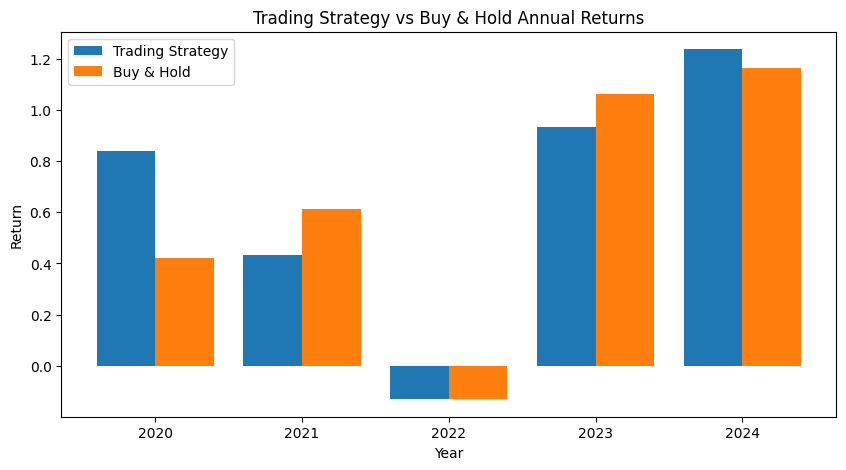

In [30]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(df, period=20, std_dev=2):
    df['SMA'] = df['Close'].rolling(window=period).mean()
    df['STD'] = df['Close'].rolling(window=period).std()
    df['Upper_BB'] = df['SMA'] + (df['STD'] * std_dev)
    df['Lower_BB'] = df['SMA'] - (df['STD'] * std_dev)
    df['BB_Width'] = df['Upper_BB'] - df['Lower_BB']  # Bollinger Band Width
    return df

# Walk-forward optimization with Bollinger Bands
def walk_forward_optimization_bollinger(df, start_year, end_year):
    results = []

    # Define dynamic ranges for Bollinger Bands parameters
    period_range = range(1, 31)  # Range for Bollinger Bands period
    std_dev_range = [1.5, 2, 2.5, 3.0]  # Range for standard deviation (multiplier)
    squeeze_period_range = range(1, 61)  # Range for rolling window in squeeze condition

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Loop through all combinations of Bollinger Bands parameters
        for params in itertools.product(period_range, std_dev_range, squeeze_period_range):
            period, std_dev, squeeze_period = params

            # Calculate Bollinger Bands on the training data
            train_data = calculate_bollinger_bands(train_data, period, std_dev)

            # Define squeeze condition
            train_data['Squeeze'] = train_data['BB_Width'] == train_data['BB_Width'].rolling(squeeze_period).min()

            # Define entry and exit conditions based on BB strategy
            entries = train_data['Squeeze']
            exits = train_data['Close'] < train_data['Lower_BB']

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (period, std_dev, squeeze_period)

        # Test with the best parameters on the test data
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]

        # Apply Bollinger Bands indicators
        yearly_data = calculate_bollinger_bands(yearly_data, best_params[0], best_params[1])

        # Apply squeeze condition
        yearly_data['Squeeze'] = yearly_data['BB_Width'] == yearly_data['BB_Width'].rolling(best_params[2]).min()

        # Keep only the second year to avoid missing values from indicator calculation
        yearly_data = yearly_data[yearly_data.index.year == test_year]

        entries = yearly_data['Squeeze']
        exits = yearly_data['Close'] < yearly_data['Lower_BB']

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'AVGO'  # AVGO! DECK VST! ^DJI! SPY
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Perform walk-forward optimization for Bollinger Bands strategy
results = walk_forward_optimization_bollinger(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']

    # Extend the data range to include the previous year for indicator calculation
    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]

    # Apply Bollinger Bands indicators
    yearly_data = calculate_bollinger_bands(yearly_data, params[0], params[1])

    # Apply squeeze condition
    yearly_data['Squeeze'] = yearly_data['BB_Width'] == yearly_data['BB_Width'].rolling(params[2]).min()

    # Keep only the second year to avoid missing values from indicator calculation
    yearly_data = yearly_data[yearly_data.index.year == year]

    # Define entry/exit conditions
    entries = yearly_data['Squeeze']
    exits = yearly_data['Close'] < yearly_data['Lower_BB']

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:  # Check if data exists for the year
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width/2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width/2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy & Hold")

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Trading Strategy vs Buy & Hold Annual Returns")
plt.legend()
plt.xticks(list(strategy_returns.keys()))

plt.show()


In [32]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,828408.885055
Total Return [%],728.408885
Benchmark Return [%],728.408885
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],48.299967
